In [20]:
from PIL import Image
import numpy as np
from matplotlib.image import pil_to_array
import healpy as hp
import matplotlib.pyplot as plt
import time
import warnings
#from pixell import reproject
import ST

In [21]:
#Gabor filter

def gabor_2d(M, N, sigma, freq):
    """
        Computes a symmetric 2D Gabor filter.
        ----------
        M, N : int
            spatial sizes
        sigma : float
            bandwidth parameter
        freq : float
            central frequency (in [0, pi])
        theta : float
            angle in [0, pi]
        offset : int, optional
            offset by which the signal starts
        Returns
        -------
        gabor_2d : ndarray
            numpy array of size (M, N)
    """
    gab = np.zeros((M, N), np.complex64)
    [x, y] = np.mgrid[-1*(M//2):(M//2),-1*(N//2):(N//2)]
    #print ()
    arg = -(x**2+y**2)/(2*sigma*sigma) + 1.j * freq*np.sqrt(x**2+y**2)
    #print (arg.shape)
    gab += np.exp(arg)

    #norm_factor = (2 * np.pi * sigma * sigma)
    #gab /= norm_factor

    return gab

In [22]:
def morlet_2d(M, N, sigma, freq):
    """
        Computes a symmetric 2D Morlet filter.
        A Morlet filter is the sum of a Gabor filter and a low-pass filter
        to ensure that the sum has exactly zero mean in the temporal domain.
        It is defined by the following formula in space:
        psi(u) = g_{sigma}(u) (e^(i xi^T u) - beta)
        where g_{sigma} is a Gaussian envelope, xi is a frequency and beta is
        the cancelling parameter.
        Parameters
        ----------
        M, N : int
            spatial sizes
        sigma : float
            bandwidth parameter
        xi : float
            central frequency (in [0, pi])
        theta : float
            angle in [0, pi]
        Returns
        -------
        morlet_2d : ndarray
            numpy array of size (M, N)
    """
    wv = gabor_2d(M, N, sigma,  freq)
    wv_modulus = gabor_2d(M, N, sigma, 0)
    K = np.sum(wv) / np.sum(wv_modulus)

    mor = wv - K * wv_modulus
    return mor

In [23]:
def comp_s1(image, morlet_arr, jmax, gaus_arr = None):
    
    s1_arr = np.zeros (jmax)
    i1_arr = []
    for j1 in range(jmax):
        
        #sigma1=0.8*2**j1
        #freq1=(3*np.pi)/(4.*2**j1)
        
        #mor1=morlet_2d(M, N, sigma1, freq1)
        #phi1=gabor_2d(M,N,sigma1,0)
        
        mor = morlet_arr[j1]
        mor_fft=np.real(np.fft.fft2(np.fft.fftshift(mor)))
        
        img_fft = np.fft.fft2(image)
        I1_fft = img_fft * mor_fft
        I1 = np.abs (np.fft.ifft2(I1_fft))
        
        
        if gaus_arr == None:
            S1 = I1
        else:
            phi = gaus_arr[j1]
            phi_fft = np.real(np.fft.fft2(np.fft.fftshift(phi)))
            U1_fft = np.fft.fft2(I1)
            S1_fft = U1*phi_fft
            S1 = np.real(np.fft.ifft2(S1_fft))
        
        i1_arr.append(S1)
        s1_arr[j1] = np.mean(S1)
    
    return s1_arr , i1_arr

In [24]:
def comp_s2 (i1_arr, morlet_arr, jmax, gaus_arr = None ):
    
    s2_arr = np.zeros ((jmax,jmax))
    i2_arr = []
    for j1 in range(jmax):
        i2_tmp = []
        i1 = i1_arr[j1]
        i1_fft = np.fft.fft2(i1)
        
        for j2 in range (jmax):
        
            mor = morlet_arr[j2]
            mor_fft=np.real(np.fft.fft2(np.fft.fftshift(mor)))

            
            I2_fft = i1_fft * mor_fft
            I2 = np.abs (np.fft.ifft2(I2_fft))


            if gaus_arr == None:
                S2 = I2
            else:
                phi = gaus_arr[j2]
                phi_fft = np.real(np.fft.fft2(np.fft.fftshift(phi)))
                U2_fft = np.fft.fft2(I2)
                S2_fft = I2*phi_fft
                S2 = np.abs(np.fft.ifft2(S2_fft))

            s2_arr[j1,j2] = np.mean(S2)
            i2_tmp.append(S2)
        i2_arr.append (i2_tmp)
    return s2_arr , i2_arr

In [25]:
# Earth image extracted from basemap:
# https://github.com/matplotlib/basemap/blob/master/lib/mpl_toolkits/basemap/data/shadedrelief.jpg
grayscale_pil_image = Image.open("/Users/arefe/Downloads/shadedrelief.jpg").convert("L")
image_array = pil_to_array(grayscale_pil_image)

In [26]:
theta_arr = np.linspace(0, np.pi, num=image_array.shape[0])[:, None]
phi_arr = np.linspace(-np.pi, np.pi, num=image_array.shape[1])

In [27]:
nside_0256 = 256
lmax_0256 = 3*nside_0256-1
ell = np.arange (lmax_0256+1)
res_0256 = hp.nside2resol (nside_0256 , arcmin = False)
res_0256_arcmin = hp.nside2resol (nside_0256 , arcmin = True)
print ("Pixel area: %.2f square degrees" % hp.nside2pixarea(nside_0256, degrees=True))

Pixel area: 0.05 square degrees


In [28]:
theta_bin = 10000
jmax = int(np.floor(np.log(2*np.pi *0.75 /res_0256 / 2)/np.log(2)))
print(jmax)


9


(array([], dtype=int64),)

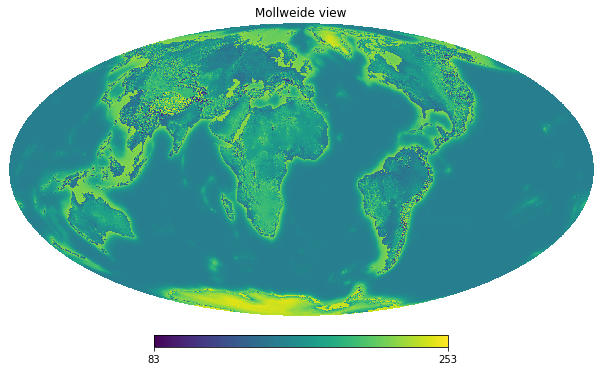

In [29]:
pix = hp.ang2pix(nside_0256, theta_arr, phi_arr)
map_earth = np.zeros(hp.nside2npix(nside_0256), dtype="float")
map_earth[pix] = image_array
#map_earth = map_earth/np.sum(np.abs(map_earth))
hp.mollview(map_earth, xsize=2000)
np.where(map_earth<0)

In [35]:
morlet_l_arr = ST.morlet_arr(res_0256 , jmax , lmax_0256 , theta_bin)

/Users/arefe/opt/anaconda3/lib/python3.8/site-packages/healpy/sphtfunc.py:1242: ComplexWarning: Casting complex values to real discards the imaginary part
  window[0] = trapz(beam * p0 * st, theta)
/Users/arefe/opt/anaconda3/lib/python3.8/site-packages/healpy/sphtfunc.py:1243: ComplexWarning: Casting complex values to real discards the imaginary part
  window[1] = trapz(beam * p1 * st, theta)
/Users/arefe/opt/anaconda3/lib/python3.8/site-packages/healpy/sphtfunc.py:1247: ComplexWarning: Casting complex values to real discards the imaginary part
  window[l] = trapz(beam * p2 * st, theta)


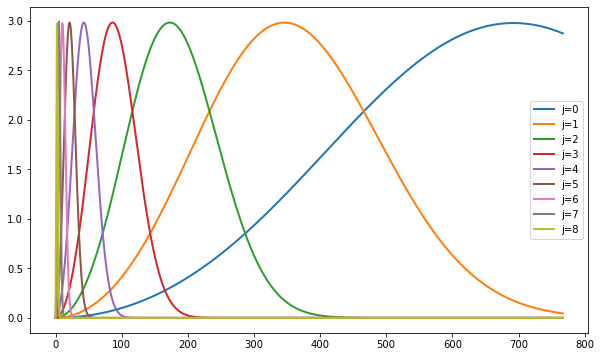

In [36]:
fig = plt.figure(figsize=[10,6])
for i in range (jmax):
    ax = plt.plot (ell, morlet_l_arr[i],label='j='+str(i), lw=2)
    plt.legend()
    
#plt.ylim (-0.001,0.01)


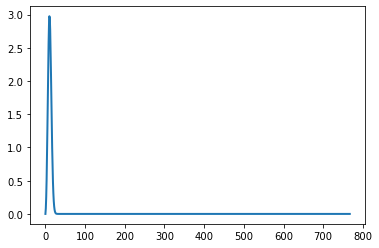

In [32]:
plt.plot (ell, morlet_l_arr[6],label='j='+str(i), lw=2)

In [37]:
alm_earth = hp.map2alm (map_earth)
almsize_0256 = alm_earth.shape[0]
mapsize_0256 = map_earth.shape[0]

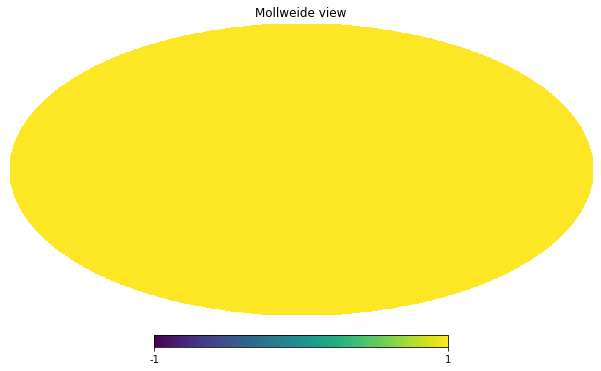

In [38]:
alm_delta_0256 = np.zeros(almsize_0256,dtype=np.complex_)
alm_delta_0256[:lmax_0256+1] = 1+0j
map_delta_0256 = hp.alm2map (alm_delta_0256, nside_0256)
map_delta_0256 += np.abs(np.min (map_delta_0256))
#map_delta_0256 = map_delta_0256/np.sum (map_delta_0256)*map_delta_0256.shape[0]
hp.mollview(map_delta_0256 , min = -1 , max =1)

In [39]:
S1_delta , i1_delta = ST.compS1 (map_delta_0256 , morlet_l_arr , jmax, nside_0256)
S2_delta , i2_delta = ST.compS2 (i1_delta, morlet_l_arr, jmax, nside_0256)

0
1
2
3
4
5
6
7
8
0
1
2
3
4
5
6
7
8


In [40]:
S1 , i1 = ST.compS1 (map_earth , morlet_l_arr , jmax, nside_0256)
S2 , i2 = ST.compS2 (i1, morlet_l_arr, jmax, nside_0256)

0
1
2
3
4
5
6
7
8
0
1
2
3
4
5
6
7
8


In [41]:
np.where(map_delta_0256<0)

(array([], dtype=int64),)

In [42]:
S0 =  np.mean (map_earth)
S0_delta = np.mean (map_delta_0256)
print (S0_delta)
S0_normalized = S0/S0_delta
print(S0**2)
S0_normalized**2

130.6704397834499
29112.59599283376


1.7050072421047004

In [43]:
S1

array([ 8.69569222,  7.0513857 ,  7.3215631 ,  9.22680392, 11.89390327,
       15.57334123, 18.21717265, 24.52742087, 21.22613903])

In [44]:
S1_delta

array([0.49977022, 0.06438531, 0.09167213, 0.13322747, 0.18963533,
       0.26860729, 0.37805343, 0.52428192, 0.71141415])

In [45]:
S2_normalized = S2/S2_delta  #/S0_delta/(4*np.pi)
S1_normalized = S1/S1_delta  #/S0_delta/(4*np.pi)
np.sum(S1_normalized**2)

36168.22361124508

In [46]:
I0sqrt =  np.mean (map_earth**2)
I0_delta = np.mean(map_delta_0256**2)
print (I0_delta)
print (I0sqrt)
I0sqrt_normalized = I0sqrt/I0_delta
print (I0sqrt_normalized)

17119.73727354647
29609.58129755656
1.729558159943814


In [47]:
S2_sum = 0
for i in range (jmax):
    for j in range (i+1 , jmax):
        S2_sum+=S2_normalized[i,j]**2
S2_sum

13775.515388442458

In [48]:
RHS = S0_normalized**2 + np.sum (S1_normalized**2) + S2_sum

In [49]:
(I0sqrt - RHS)/I0sqrt

-0.6868000768065988

In [32]:
(I0sqrt-S0_normalized**2)/I0sqrt

0.014194907351315093

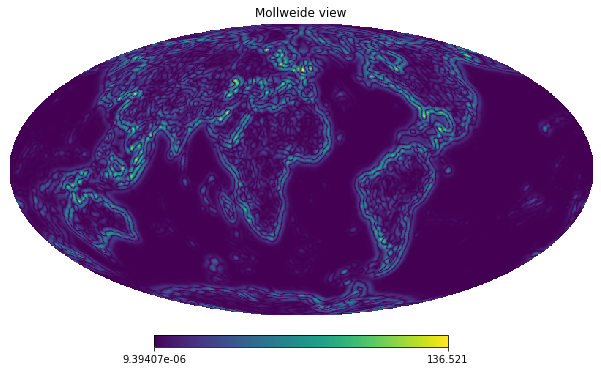

In [50]:
hp.mollview (i1[3])

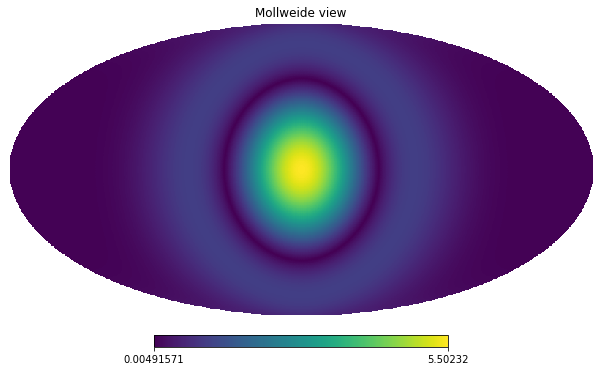

In [53]:
hp.mollview(i1_delta[8] , rot  = [0, 90])

In [96]:
S1/S1_delta

array([ 14.63621353, 126.6176053 ,  86.09159079,  72.66474187,
        67.7930163 ,  62.40375429,  57.84426586,  48.26947889,
        46.66696593,  29.75405927])

In [47]:
map_delta_prj = np.zeros (mapsize_0256)

In [28]:
len(morlet_l_arr[0])

1536

In [30]:
mapsize_0256

3145728

In [39]:
x_dim = image_array.shape[0]
y_dim = image_array.shape[1]
jmax = int (np.floor(np.log (min(x_dim,y_dim))/np.log(2))+1)
jmax

13

In [41]:
# making a list of morlet maps

morlet_arr = []
for j in range (jmax):
    sigma=0.8*2**j
    freq=(3*np.pi)/(4.*2**j)
    mor = morlet_2d (x_dim, y_dim, sigma, freq)
    morlet_arr.append(mor)
    
    

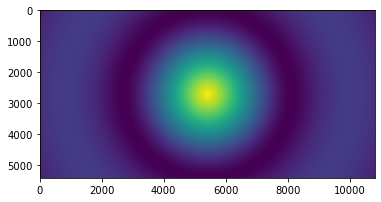

In [43]:
plt.imshow(np.abs(morlet_arr[12]))

In [44]:
map_morlet_arr = []
for j in range (jmax):
    pix = hp.ang2pix(nside_0256, theta_arr, phi_arr)
    map_morlet = np.zeros(hp.nside2npix(nside_0256), dtype="float")
    map_morlet[pix] = morlet_arr[j]
    #map_earth = map_earth/np.sum(np.abs(map_earth))
    map_morlet_arr.append(map_morlet)
    #hp.title("Mollweide view of the Earth")


<ipython-input-44-ba2621258be7>:5: ComplexWarning: Casting complex values to real discards the imaginary part
  map_morlet[pix] = morlet_arr[j]


In [54]:
hp.mollview(map_morlet_arr[0] , rot = [0, 90])    

NameError: name 'map_morlet_arr' is not defined

In [37]:
bl_test = np.ones (lmax_0256+1) *3
alm_test = np.arange (0,almsize_0256)+1.j
alm_test = hp.almxfl (alm_test , bl_test)
map_testt = hp.alm2map (alm_test , nside=nside_0256)

In [11]:
jk=np.array ([[1,2,3],[1,2,3], [1,2,3]])
np.sum (jk)

18